In [8]:
import gym
gym.logger.set_level(0)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
# set the random seed
torch.manual_seed(0)
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical

In [11]:
env = gym.make('CartPole-v1')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=16, action_dim=2):
        super(Policy, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return F.softmax(self.model(x), dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


### Train the agent with REINFORCE

In [15]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(num_episodes=10000, max_t=1000,gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, num_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 12.79
Episode 200	Average Score: 16.21
Episode 300	Average Score: 17.73
Episode 400	Average Score: 22.48
Episode 500	Average Score: 30.93
Episode 600	Average Score: 23.92
Episode 700	Average Score: 35.23
Episode 800	Average Score: 58.34
Episode 900	Average Score: 56.38
Episode 1000	Average Score: 61.74
Episode 1100	Average Score: 54.27
Episode 1200	Average Score: 49.82
Episode 1300	Average Score: 52.86
Episode 1400	Average Score: 50.40
Episode 1500	Average Score: 134.36
Episode 1600	Average Score: 52.64
Episode 1700	Average Score: 52.10
Episode 1800	Average Score: 56.11
Episode 1900	Average Score: 65.78
Episode 2000	Average Score: 64.96
Episode 2100	Average Score: 72.98
Episode 2200	Average Score: 87.47
Episode 2300	Average Score: 69.10
Episode 2400	Average Score: 71.15
Episode 2500	Average Score: 64.58
Episode 2600	Average Score: 75.35
Episode 2700	Average Score: 106.22
Episode 2800	Average Score: 62.92
Episode 2900	Average Score: 68.91
Episode 3000	Average 

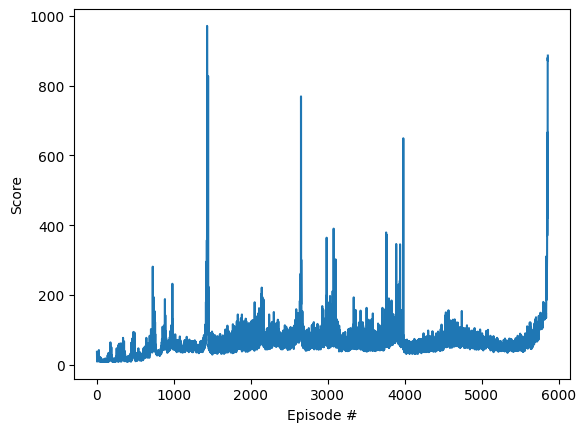

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [27]:
import time

env = gym.make('CartPole-v1',render_mode='rgb_array')

state = env.reset()[0]
# img = plt.imshow(env.render())
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    time.sleep(0.1)
    
    state, reward, done, _, _ = env.step(action)
    if done:
        break 

env.close()

KeyboardInterrupt: 